In [1]:
# Author: C. Hull (github: chat.hull)

# This is a project analyzing historical data of the air quality in Santiago, Chile

# The data for a representative weather station in central Santiago can be found here:
# https://sinca.mma.gob.cl/index.php/estacion/index/key/D11

# Shout-outs to the many posts/github pages that helped me out!
# Julia Kho: web scraping, https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460
# Aditya Sharma: time-series moving averages, https://www.datacamp.com/community/tutorials/moving-averages-in-pandas
# Manish Pathak: concatenating/merging in pandas, https://www.datacamp.com/community/tutorials/joining-dataframes-pandas
# Laura Fedoruk: time-series manipulation in pandas, https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea

# Making a small change

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import requests
from bs4 import BeautifulSoup
import time
from datetime import date
from matplotlib import pyplot as plt

In [3]:
def isfloat(x) :
    try:
        float(x)
        return True
    except:
        return False

In [4]:
# Scrape SINCA website

# Many pollutants, but different stations don't have continuous time coverage of all of them
# SO2, NO, NO2, CO, O3, NOX, non-methanic hydrocarbons, PM10, PM2.5

# For now, focus on PM10, PM2.5, and weather data at Independencia Station
station = 'D11'
# Earliest common date is 031215 (constrained by weather data)
date_from = '031215'
# Current date
date_to = date.today().strftime("%y%m%d")

#PM2.5
pm25 = {
    'name' : 'pm2.5',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM25//PM25.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

#PM10
pm10 = {
    'name' : 'pm10',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM10//PM10.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Relative humidity
rhum = {
    'name' : 'rhum',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/RHUM//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Temperature
temp = {
    'name' : 'temp',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/TEMP//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind speed
wspd = {
    'name' : 'wspd',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WSPD//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind direction
wdir = {
    'name' : 'wdir',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WDIR//horario_000_spec.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

In [5]:
def scrapeData(series_url) :
    time.sleep(1)
    response = requests.get(series_url)
    print response    
    return response

def formatData(html_response) :
    data = html_response.text.split('\n')
    # Clear header and footer text
    data = [ line for line in data if len(line) and isfloat(line[0]) ]
    # Keep lines with date, time, and validated or preliminary data
    data = [ line.split(',')[0:4] for line in data if \
            isfloat(line.split(',')[2]) or isfloat(line.split(',')[3]) ]
    return data

In [6]:
# Empty dataframe; will merge other columns into it one by one
df_tot = pd.DataFrame(columns=['datetime'])

for series in [pm25, pm10, rhum, temp, wspd, wdir] :
    response = scrapeData(series['url'])
    data = formatData(response)
    
    # Format dates
    df = pd.DataFrame.from_records(data, columns=['date', 'time', 'validated', 'preliminary'])
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%y%m%d %H%M')
    df = df.drop(columns=['date', 'time'])
    
    # Combine validated and preliminary-data columns (after replacing white space with NaNs)
    df = df.replace(r'^\s+$', np.nan, regex=True)
    df[series['name']] = df['validated'].combine_first(df['preliminary'])
    df = df.drop(columns=['validated','preliminary'])
    
    # Convert unicode to floats
    df[series['name']] = pd.to_numeric(df[series['name']])
    
    # Merge latest time-series into full DataFrame, resort index
    df_tot = pd.merge(df_tot, df, on='datetime', how='outer')
    df_tot = df_tot.sort_values('datetime')
    df_tot = df_tot.reset_index(drop=True)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [7]:
print df_tot.tail(n=15)

                  datetime  pm2.5  pm10     rhum      temp      wspd  \
137649 2019-09-26 03:00:00   26.0  43.0  95.6045   8.20262  0.832334   
137650 2019-09-26 04:00:00   33.0  61.0  96.6865   8.16911  0.347343   
137651 2019-09-26 05:00:00   32.0  63.0  94.6667   8.36665  0.622898   
137652 2019-09-26 06:00:00   30.0  62.0  94.1667   8.55000  0.404483   
137653 2019-09-26 07:00:00   36.0  71.0  94.9156   8.45190  0.334613   
137654 2019-09-26 08:00:00   41.0  87.0  94.1667   8.67500  0.787355   
137655 2019-09-26 09:00:00   38.0  86.0  89.9092   9.37500  1.044280   
137656 2019-09-26 10:00:00    NaN   NaN  89.4167   9.49167  1.007420   
137657 2019-09-26 11:00:00    NaN   NaN  79.7500  11.79170  1.236550   
137658 2019-09-26 12:00:00    NaN   NaN  65.4167  15.29170  0.996792   
137659 2019-09-26 13:00:00    NaN   NaN  53.0833  18.75000  0.581751   
137660 2019-09-26 14:00:00    NaN   NaN  43.6667  21.45000  1.323520   
137661 2019-09-26 15:00:00    NaN   NaN  43.9167  21.76670  2.06

In [8]:
df_tot['pm2.5run'] = df_tot['pm2.5'].rolling(window=4).mean()
df_tot['pm10run']  = df_tot['pm10'].rolling(window=4).mean()
df_tot['rhumrun']  = df_tot['rhum'].rolling(window=4).mean()
df_tot['temprun']  = df_tot['temp'].rolling(window=4).mean()
df_tot['wspdrun']  = df_tot['wspd'].rolling(window=4).mean()
df_tot['wdirrun']  = df_tot['wdir'].rolling(window=4).mean()

In [9]:
# Set datetime column as the index of the dataframe
df_tot = df_tot.set_index('datetime')

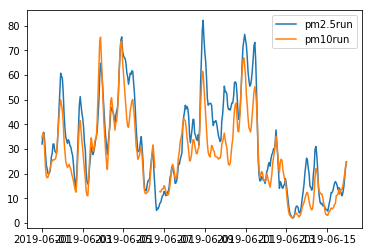

In [20]:
# Sample plots
t_min='2019-06-01'
t_max='2019-06-15'
plt.plot(df_tot['pm2.5run'][t_min:t_max],'-')
plt.plot(0.3*df_tot['pm10run'][t_min:t_max],'-')
plt.legend()

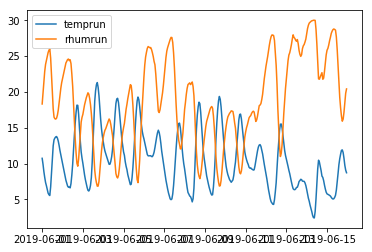

In [11]:
# Sample plots
t_min='2019-06-01'
t_max='2019-06-15'
plt.plot(df_tot['temprun'][t_min:t_max],'-')
plt.plot(0.3*df_tot['rhumrun'][t_min:t_max],'-')
plt.legend()

In [12]:
# TODO: 
# Do PCA on the time series and remove the signals?
# Test correlations: positive (PM2.5 and PM10), and negative (temp and rhum)

In [13]:
# TESTS

In [33]:
df_tot['pm2.5'].resample('Y').mean()

datetime
2003-12-31          NaN
2004-12-31          NaN
2005-12-31          NaN
2006-12-31          NaN
2007-12-31          NaN
2008-12-31          NaN
2009-12-31    28.580491
2010-12-31    25.205122
2011-12-31    24.859357
2012-12-31    23.363694
2013-12-31    24.480456
2014-12-31    28.799351
2015-12-31    31.033043
2016-12-31    29.022517
2017-12-31    28.178165
2018-12-31    26.960916
2019-12-31    29.927539
Freq: A-DEC, Name: pm2.5, dtype: float64